# Course 6 End-of-course project: Predicting tips

In this activity, you will practice using tree-based modeling techniques to predict on a binary target class.  
<br/>   

**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.  
  
**The goal** of this model is to predict whether or not a customer is a generous tipper.  
<br/>  


# **Predict tips using machine learning**

You are a data professional in a data analytics firm called Automatidata. Their client, the New York City Taxi & Limousine Commission (New York City TLC), was impressed with the work you have done and has requested that you **build a machine learning model to predict if a customer will not leave a tip**. They want to use the model in an app that will alert taxi drivers to customers who are unlikely to tip, since drivers depend on tips, and the ability to filter out people who don't tip would help increase driver revenue. 

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score,accuracy_score,\
confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import pickle
import datetime
pd.options.display.max_columns = None 

In [2]:
df = pd.read_csv('Transformed_2017_Yellow_Taxi_Trip_Data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22659 entries, 0 to 22658
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0.1           22659 non-null  int64  
 1   Unnamed: 0             22659 non-null  int64  
 2   VendorID               22659 non-null  int64  
 3   tpep_pickup_datetime   22659 non-null  object 
 4   tpep_dropoff_datetime  22659 non-null  object 
 5   passenger_count        22659 non-null  int64  
 6   trip_distance          22659 non-null  float64
 7   RatecodeID             22659 non-null  int64  
 8   store_and_fwd_flag     22659 non-null  object 
 9   PULocationID           22659 non-null  int64  
 10  DOLocationID           22659 non-null  int64  
 11  payment_type           22659 non-null  int64  
 12  fare_amount            22659 non-null  float64
 13  extra                  22659 non-null  float64
 14  mta_tax                22659 non-null  float64
 15  ti

You know from your EDA that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, you'll need to sample the data to select only the customers who pay with credit card. 

Copy `df0` and assign the result to a variable called `df`. Then, use a Boolean mask to filter `df1` so it contains only customers who paid with credit card.

In [4]:
df1 = df.loc[df['payment_type']==1]

##### **Target**

Notice that there isn't a column that indicates tip percent, which is what you need to create the target variable. You'll have to engineer it. 

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  


In [5]:
def generous(row):
    if row['tip_amount']/(row['total_amount']-row['tip_amount'])>=0.2:
        row['generous'] = 1
    else:
        row['generous'] = 0
    return row

df1 = df1.apply(generous, axis=1)
df1.head()

,Unnamed: 0.1,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Trip_duration,generous
0,0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,0 days 00:14:04,1
1,1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,0 days 00:26:30,1
2,2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,0 days 00:07:12,0
3,3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,0 days 00:30:15,1
5,5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,0 days 00:08:00,1


In [6]:
df = df1.loc[:,~df1.columns.isin(['Unnamed: 0.1', 'Unnamed: 0'])]

In [7]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['trip_duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['trip_duration_in_seconds'] = df['trip_duration'].apply(lambda x: x.total_seconds())

C:\Users\brilenkov_i\AppData\Local\Temp\ipykernel_5368\274084217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
C:\Users\brilenkov_i\AppData\Local\Temp\ipykernel_5368\274084217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
C:\Users\brilenkov_i\AppData\Local\Temp\ipykernel_5368\274084217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a cop

Create a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [8]:
df['day'] = df['tpep_pickup_datetime'].dt.day_name()



To convert to day name, use `dt.day_name()` on the column.
</details>

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)

To do this, first create the four columns. For now, each new column should contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [9]:
df['am_rush'] = 0 
df['daytime'] = 0 
df['pm_rush'] = 0 
df['nighttime'] = 0 

def trip_time_bins(row):
    if 6 <= row['tpep_pickup_datetime'].hour < 10:
        row['am_rush'] = 1
    elif 10 <= row['tpep_pickup_datetime'].hour < 16:
        row['daytime'] = 1
    elif 16 <= row['tpep_pickup_datetime'].hour < 20:
        row['pm_rush'] = 1
    elif 20 <= row['tpep_pickup_datetime'].hour or row['tpep_pickup_datetime'].hour < 6:
        row['nighttime'] = 1
    return row

df = df.apply(trip_time_bins, axis=1)

In [10]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Trip_duration,generous,trip_duration,trip_duration_in_seconds,day,am_rush,daytime,pm_rush,nighttime
0,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,0 days 00:14:04,1,0 days 00:14:04,844.0,Saturday,1,0,0,0
1,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,0 days 00:26:30,1,0 days 00:26:30,1590.0,Tuesday,0,1,0,0
2,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,0 days 00:07:12,0,0 days 00:07:12,432.0,Friday,1,0,0,0
3,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,0 days 00:30:15,1,0 days 00:30:15,1815.0,Sunday,0,1,0,0
5,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,0 days 00:08:00,1,0 days 00:08:00,480.0,Saturday,0,0,0,1


Now, create a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

In [11]:
df['month'] = df['tpep_pickup_datetime'].dt.strftime('%b')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Trip_duration,generous,trip_duration,trip_duration_in_seconds,day,am_rush,daytime,pm_rush,nighttime,month
0,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,0 days 00:14:04,1,0 days 00:14:04,844.0,Saturday,1,0,0,0,Mar
1,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,0 days 00:26:30,1,0 days 00:26:30,1590.0,Tuesday,0,1,0,0,Apr
2,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,0 days 00:07:12,0,0 days 00:07:12,432.0,Friday,1,0,0,0,Dec
3,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,0 days 00:30:15,1,0 days 00:30:15,1815.0,Sunday,0,1,0,0,May
5,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,0 days 00:08:00,1,0 days 00:08:00,480.0,Saturday,0,0,0,1,Mar


Because you have encoded much of the information contained in the pickup and dropoff columns into new columns, you can drop them for modeling. 

1. Drop the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns and reassign the result back to `df1`.

In [12]:
df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)

Examine the first five rows of your dataframe.

In [13]:
df.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Trip_duration,generous,trip_duration,trip_duration_in_seconds,day,am_rush,daytime,pm_rush,nighttime,month
0,2,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,0 days 00:14:04,1,0 days 00:14:04,844.0,Saturday,1,0,0,0,Mar
1,1,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,0 days 00:26:30,1,0 days 00:26:30,1590.0,Tuesday,0,1,0,0,Apr
2,1,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,0 days 00:07:12,0,0 days 00:07:12,432.0,Friday,1,0,0,0,Dec
3,2,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,0 days 00:30:15,1,0 days 00:30:15,1815.0,Sunday,0,1,0,0,May
5,2,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,0 days 00:08:00,1,0 days 00:08:00,480.0,Saturday,0,0,0,1,Mar


Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, you'll first need to convert them to `type(str)`. 

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_string` to string.


In [14]:
df['RatecodeID'] = df['RatecodeID'].astype('str')
df['PULocationID'] = df['PULocationID'].astype('str')
df['DOLocationID'] = df['DOLocationID'].astype('str')



To convert to string, use `astype(str)` on the column.
</details>

The `VendorID` column is also a numerical column that contains categorical information (which taxi cab company picked up the passenger). The values are all 1 or 2. 

1. Convert this to binary by subtracting 1 from every value in the column.

In [15]:
df['VendorID'] -= 1

Now convert all the categorical columns to binary.

1. Call `get_dummies()` on the dataframe and assign the results back to a new dataframe called `df2`. Don't use the `drop_first` parameter.


In [18]:
df2 = df.drop(['payment_type', 'mta_tax', 'tip_amount', 'total_amount', 'Trip_duration', 'trip_duration'], axis=1)

In [19]:
df2 = pd.get_dummies(df2)

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15235 entries, 0 to 22658
Columns: 356 entries, VendorID to month_Sep
dtypes: float64(6), int64(7), uint8(343)
memory usage: 6.6 MB


In [21]:
df2.head()

,VendorID,passenger_count,trip_distance,fare_amount,extra,tolls_amount,improvement_surcharge,generous,trip_duration_in_seconds,am_rush,daytime,pm_rush,nighttime,RatecodeID_1,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,store_and_fwd_flag_N,store_and_fwd_flag_Y,PULocationID_1,PULocationID_10,PULocationID_100,PULocationID_106,PULocationID_107,PULocationID_112,PULocationID_113,PULocationID_114,PULocationID_116,PULocationID_12,PULocationID_123,PULocationID_125,PULocationID_127,PULocationID_128,PULocationID_129,PULocationID_13,PULocationID_130,PULocationID_131,PULocationID_132,PULocationID_133,PULocationID_134,PULocationID_135,PULocationID_137,PULocationID_138,PULocationID_140,PULocationID_141,PULocationID_142,PULocationID_143,PULocationID_144,PULocationID_145,PULocationID_146,PULocationID_148,PULocationID_151,PULocationID_152,PULocationID_153,PULocationID_158,PULocationID_161,PULocationID_162,PULocationID_163,PULocationID_164,PULocationID_166,PULocationID_17,PULocationID_170,PULocationID_173,PULocationID_179,PULocationID_181,PULocationID_186,PULocationID_188,PULocationID_189,PULocationID_190,PULocationID_193,PULocationID_196,PULocationID_208,PULocationID_209,PULocationID_211,PULocationID_213,PULocationID_216,PULocationID_218,PULocationID_223,PULocationID_224,PULocationID_225,PULocationID_226,PULocationID_229,PULocationID_230,PULocationID_231,PULocationID_232,PULocationID_233,PULocationID_234,PULocationID_236,PULocationID_237,PULocationID_238,PULocationID_239,PULocationID_24,PULocationID_243,PULocationID_244,PULocationID_246,PULocationID_247,PULocationID_249,PULocationID_25,PULocationID_255,PULocationID_256,PULocationID_258,PULocationID_260,PULocationID_261,PULocationID_262,PULocationID_263,PULocationID_264,PULocationID_265,PULocationID_28,PULocationID_33,PULocationID_35,PULocationID_36,PULocationID_37,PULocationID_4,PULocationID_40,PULocationID_41,PULocationID_42,PULocationID_43,PULocationID_45,PULocationID_48,PULocationID_49,PULocationID_50,PULocationID_52,PULocationID_57,PULocationID_61,PULocationID_62,PULocationID_65,PULocationID_66,PULocationID_68,PULocationID_7,PULocationID_70,PULocationID_74,PULocationID_75,PULocationID_79,PULocationID_80,PULocationID_82,PULocationID_87,PULocationID_88,PULocationID_90,PULocationID_91,PULocationID_92,PULocationID_93,PULocationID_95,PULocationID_97,DOLocationID_1,DOLocationID_10,DOLocationID_100,DOLocationID_102,DOLocationID_106,DOLocationID_107,DOLocationID_11,DOLocationID_112,DOLocationID_113,DOLocationID_114,DOLocationID_116,DOLocationID_117,DOLocationID_118,DOLocationID_119,DOLocationID_12,DOLocationID_120,DOLocationID_121,DOLocationID_123,DOLocationID_124,DOLocationID_125,DOLocationID_126,DOLocationID_127,DOLocationID_129,DOLocationID_13,DOLocationID_130,DOLocationID_131,DOLocationID_132,DOLocationID_133,DOLocationID_134,DOLocationID_135,DOLocationID_136,DOLocationID_137,DOLocationID_138,DOLocationID_14,DOLocationID_140,DOLocationID_141,DOLocationID_142,DOLocationID_143,DOLocationID_144,DOLocationID_145,DOLocationID_146,DOLocationID_147,DOLocationID_148,DOLocationID_15,DOLocationID_151,DOLocationID_152,DOLocationID_153,DOLocationID_157,DOLocationID_158,DOLocationID_159,DOLocationID_16,DOLocationID_160,DOLocationID_161,DOLocationID_162,DOLocationID_163,DOLocationID_164,DOLocationID_166,DOLocationID_168,DOLocationID_169,DOLocationID_17,DOLocationID_170,DOLocationID_173,DOLocationID_174,DOLocationID_175,DOLocationID_177,DOLocationID_178,DOLocationID_179,DOLocationID_180,DOLocationID_181,DOLocationID_182,DOLocationID_183,DOLocationID_186,DOLocationID_188,DOLocationID_189,DOLocationID_19,DOLocationID_192,DOLocationID_193,DOLocationID_194,DOLocationID_195,DOLocationID_196,DOLocationID_197,DOLocationID_198,DOLocationID_200,DOLocationID_202,DOLocationID_208,DOLocationID_209,DOLocationID_21,DOLocationID_210,DOLocationID_211,DOLocationID_212,DOLocationID_213,DOLocationID_216,DOLocationID_217,DOLocationID_218,DOLocationID_22,DOLocationID_220,DOLocationID_223,DOLocationID_224,DOLocationID_225,

##### **Evaluation metric**

Before modeling, you must decide on an evaluation metric. 

1. Examine the class balance of your target variable. 

In [23]:
df2['generous'].value_counts()

0    9918
1    5317
Name: generous, dtype: int64

Approximately 1/3 of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is imbalanced, but not extremely so. 

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receiving one.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more.

##### **Split the data**

Now you're ready to model. The only remaining step is to split the data into features/target variable and training/testing data. 

1. Define a variable `y` that isolates the target variable (`generous`).
2. Define a variable `X` that isolates the features.
3. Split the data into training and testing sets. Put 20% of the samples into the test set, stratify the data, and set the random state.

In [24]:
y = df2['generous']
X = df2.drop('generous', axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

##### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take. 
 - `max_depth`  
 - `max_features`  
 - `max_samples` 
 - `min_samples_leaf`  
 - `min_samples_split`
 - `n_estimators`  

3. Define a dictionary `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf_cv1`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of you cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)


**Note:** `refit` should be set to `'precision'`.<font/>
</details>
 


In [72]:
rf = RandomForestClassifier()

cv_params = {'max_depth'        : [20, None],
             'max_features'     : [10, 70, 200],
#              'max_samples'      : [2,3],
             'min_samples_leaf' : [1,2,4],
             'min_samples_split': [1,2,4],
             'n_estimators'     : [75, 110]
            }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

rf_cv1 = GridSearchCV(estimator=rf, param_grid=cv_params, scoring=scoring, cv=3, refit='precision')

Now fit the model to the training data.

In [73]:
%%time
rf_cv1.fit(X_train, y_train)

C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
108 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\

CPU times: total: 18min 24s
Wall time: 18min 27s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [20, None], 'max_features': [10, 70, 200],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [1, 2, 4],
                         'n_estimators': [75, 110]},
             refit='precision',
             scoring={'recall', 'precision', 'accuracy', 'f1'})

If you want, use `pickle` to save your models and read them back in. This can be particularly helpful when performing a search over many possible hyperparameter values.

In [75]:
# with open('project6_rf.pickle', 'wb') as to_write:
#     pickle.dump(rf_cv1, to_write) 

Examine the best average score across all the validation folds. 

In [76]:
rf_cv1.best_score_

0.7599976749593118

Examine the best combination of hyperparameters.

In [77]:
rf_cv1.best_params_

{'max_depth': 20,
 'max_features': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 110}

In [44]:
def make_results(model_name:str, model_object, metric:str):
      # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                     'recall': 'mean_test_recall',
                     'f1': 'mean_test_f1',
                     'accuracy': 'mean_test_accuracy',
                     }

  # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

  # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

  # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
  # Create table of results
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                        'Precision': precision,
                        'Recall': recall,
                        'F1': f1,
                        'Accuracy': accuracy,
                        },
                        ignore_index=True
                       )
  
    return table

Call `make_results()` on the GridSearch object.

In [78]:
make_results(rf, rf_cv1, 'precision')

C:\Users\brilenkov_i\AppData\Local\Temp\ipykernel_5368\323243914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


,Model,Precision,Recall,F1,Accuracy
0,RandomForestClassifier(),0.759998,0.026093,0.050002,0.656712


The precision seems satisfactory, but not great. The other scores are very bad. 

A model with such low F1 and recall scores is not good enough. Try retuning the model to select based on F1 score instead. Consider adjusting the hyperparameters that you try based on the results of the above model. 

For example, if the available values for `min_samples_split` were [2, 3, 4] and GridSearch identified the best value as 4, consider trying [4, 5, 6] this time.
</details>

In [79]:
rf = RandomForestClassifier()

cv_params = {'max_depth'        : [10, 20, 30],
             'max_features'     : [5, 7, 10],
             'min_samples_leaf' : [4, 5, 6],
             'min_samples_split': [2],
             'n_estimators'     : [110, 150, 200]
            }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

rf_cv1 = GridSearchCV(estimator=rf, param_grid=cv_params, scoring=scoring, cv=3, refit='f1')

In [80]:
%%time
rf_cv1.fit(X_train, y_train)

C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\b

C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\b

C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\b

C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\b

C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\b

C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\b

C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brilenkov_i\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\b

CPU times: total: 4min 31s
Wall time: 4min 33s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 30], 'max_features': [5, 7, 10],
                         'min_samples_leaf': [4, 5, 6],
                         'min_samples_split': [2],
                         'n_estimators': [110, 150, 200]},
             refit='f1', scoring={'recall', 'precision', 'accuracy', 'f1'})

In [81]:
rf_cv1.best_score_

0.1148560410182523

In [82]:
rf_cv1.best_params_

{'max_depth': 30,
 'max_features': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 150}

In [83]:
make_results(rf, rf_cv1, 'f1')

C:\Users\brilenkov_i\AppData\Local\Temp\ipykernel_5368\323243914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


,Model,Precision,Recall,F1,Accuracy
0,RandomForestClassifier(),0.675214,0.063235,0.114856,0.662209


There was a modest improvement in both F1 and recall scores, but these results still are not good enough to deploy the model.

In [89]:
y_pred = rf_cv1.best_estimator_.predict(X_test)

In [92]:
print('F1 score final rf model: {:.2f}'.format(f1_score(y_test, y_pred)))
print('Recall score final rf model: {:.2f}'.format(recall_score(y_test, y_pred)))
print('Precision score final rf model: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Accuracy score final rf model: {:.2f}'.format(accuracy_score(y_test, y_pred)))

F1 score final rf model: 0.13
Recall score final rf model: 0.07
Precision score final rf model: 0.74
Accuracy score final rf model: 0.67


##### **XGBoost**

 Try to improve your scores using an XGBoost model. 

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a dictionary `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb_cv1`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of you cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='f1'`)

In [107]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0) 

cv_params = {'max_depth': [8,10,15], 
             'min_child_weight': [5,6,8],
             'learning_rate': [0.05, 0.1],
             'n_estimators': [125,150, 200]
             }    

scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv2 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [104]:
# with open('project6_xgb.pickle', 'wb') as to_write:
#     pickle.dump(xgb_cv1, to_write) 

Now fit the model to the `X_train` and `y_train` data.

In [108]:
%%time
xgb_cv2.fit(X_train, y_train)

CPU times: total: 7h 9min 19s
Wall time: 1h 21s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [8, 10, 15],
                         'min_child_weight': [5, 6, 8],
                         'n_estimators': [125, 150, 200]},
             refit='f1', scoring={'recall', 'precision', 'accuracy', 'f1'})

In [113]:
# with open('project6_xgb2.pickle', 'wb') as to_write:
#     pickle.dump(xgb_cv2, to_write) 

Get the best score from this model.

In [96]:
xgb_cv1.best_score_

0.521852009213976

In [110]:
xgb_cv2.best_score_

0.5433494850991731

And the best parameters.

In [97]:
xgb_cv1.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 5,
 'n_estimators': 125}

In [109]:
xgb_cv2.best_params_

{'learning_rate': 0.05,
 'max_depth': 15,
 'min_child_weight': 6,
 'n_estimators': 125}

Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

In [95]:
make_results(xgb, xgb_cv1, 'f1')

C:\Users\brilenkov_i\AppData\Local\Temp\ipykernel_5368\323243914.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


,Model,Precision,Recall,F1,Accuracy
0,"XGBClassifier(base_score=None, booster=None, c...",0.647163,0.437472,0.521852,0.720135


Use your model to predict on the test data. Assign the results to a variable called `preds`.


You cannot call `predict()` on the GridSearchCV object directly. You must call it on the `best_estimator_`.
</details>

In [98]:
y_pred = xgb_cv1.best_estimator_.predict(X_test)

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `xgb_cv_test_scores`.
2. Call `xgb_cv_test_scores` to output the results. 

In [99]:
print('F1 score final xgb model: {:.2f}'.format(f1_score(y_test, y_pred)))
print('Recall score final xgb model: {:.2f}'.format(recall_score(y_test, y_pred)))
print('Precision score final xgb model: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Accuracy score final xgb model: {:.2f}'.format(accuracy_score(y_test, y_pred)))

F1 score final xgb model: 0.54
Recall score final xgb model: 0.45
Precision score final xgb model: 0.68
Accuracy score final xgb model: 0.73


In [111]:
y_pred2 = xgb_cv2.best_estimator_.predict(X_test)

In [112]:
print('F1 score final xgb model: {:.2f}'.format(f1_score(y_test, y_pred2)))
print('Recall score final xgb model: {:.2f}'.format(recall_score(y_test, y_pred2)))
print('Precision score final xgb model: {:.2f}'.format(precision_score(y_test, y_pred2)))
print('Accuracy score final xgb model: {:.2f}'.format(accuracy_score(y_test, y_pred2)))

F1 score final xgb model: 0.55
Recall score final xgb model: 0.47
Precision score final xgb model: 0.67
Accuracy score final xgb model: 0.73


Plot a confusion matrix of the model's predictions on the test data.

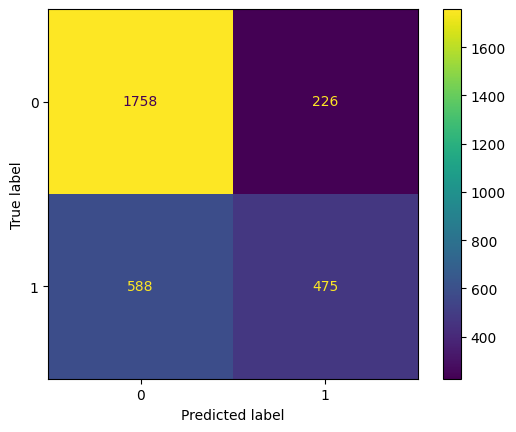

In [100]:
cm = confusion_matrix(y_test, y_pred, labels=xgb_cv1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv1.classes_)
disp.plot();

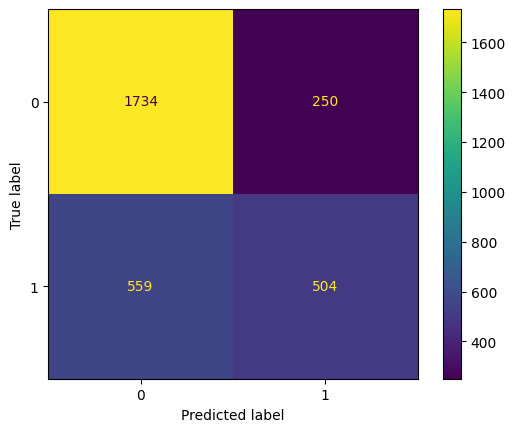

In [115]:
cm = confusion_matrix(y_test, y_pred2, labels=xgb_cv2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv2.classes_)
disp.plot();

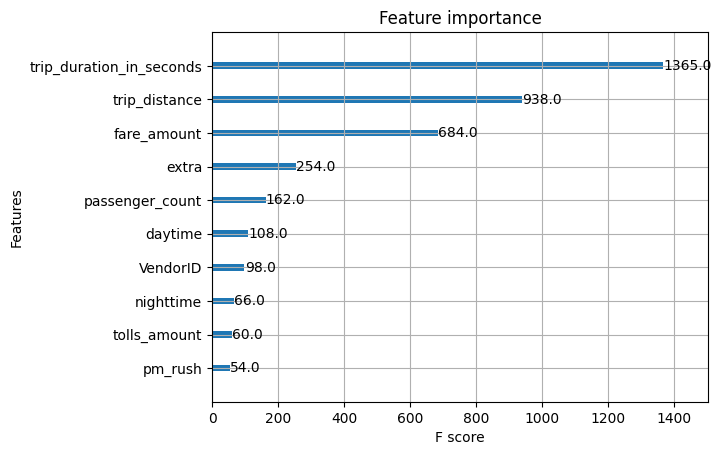

In [103]:
plot_importance(xgb_cv1.best_estimator_, max_num_features=10);

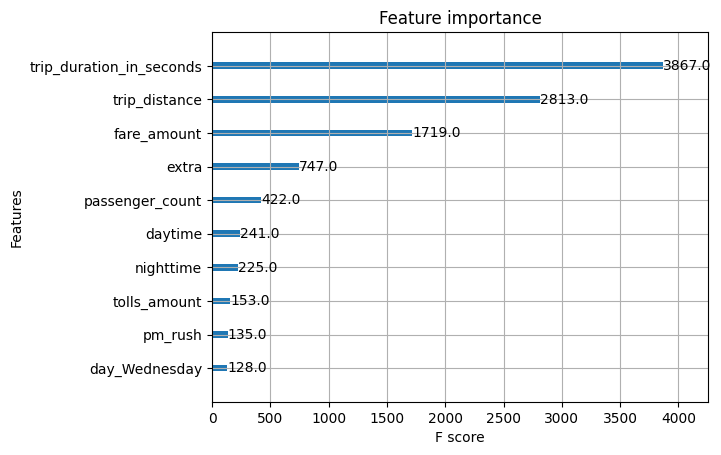

In [116]:
plot_importance(xgb_cv2.best_estimator_, max_num_features=10);